In [5]:
# !apt-get install p7zip
# !wget https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z
# !7z x yoochoose-data.7z
# !rm yoochoose-data.7z

In [23]:
import argparse
import logging
import datetime

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import torch

%matplotlib inline

In [7]:
clicks = pd.read_csv('yoochoose-clicks.dat', header=None, low_memory=False,
                     dtype={0:np.int32, 1:str, 2:np.int64, 3:str},
                     names=["session_id", "timestamp", "item_id", "category"])
clicks[:10]

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0
5,2,2014-04-07T13:57:19.373Z,214662742,0
6,2,2014-04-07T13:58:37.446Z,214825110,0
7,2,2014-04-07T13:59:50.710Z,214757390,0
8,2,2014-04-07T14:00:38.247Z,214757407,0
9,2,2014-04-07T14:02:36.889Z,214551617,0


In [8]:
buys = pd.read_csv('yoochoose-buys.dat', header=None, low_memory=False,
                   dtype={0:np.int32, 1:str, 2:np.int64, 3:np.int64, 4:np.int64},
                   names=["session_id", "timestamp", "item_id", "price", "quantity"])
buys[:10]

,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1
5,140806,2014-04-07T09:22:28.132Z,214668193,523,1
6,140806,2014-04-07T09:22:28.176Z,214587399,1046,1
7,140806,2014-04-07T09:22:28.219Z,214586690,837,1
8,140806,2014-04-07T09:22:28.268Z,214774667,1151,1
9,140806,2014-04-07T09:22:28.280Z,214578823,1046,1


In [9]:
query = "session_id==@session_id"
session_id = 11
print(clicks.query(query))
print(buys.query(query))

    session_id                 timestamp    item_id category
24          11  2014-04-03T10:44:35.672Z  214821275        0
25          11  2014-04-03T10:45:01.674Z  214821275        0
26          11  2014-04-03T10:45:29.873Z  214821371        0
27          11  2014-04-03T10:46:12.162Z  214821371        0
28          11  2014-04-03T10:46:57.355Z  214821371        0
29          11  2014-04-03T10:53:22.572Z  214717089        0
30          11  2014-04-03T10:53:49.875Z  214563337        0
31          11  2014-04-03T10:55:19.267Z  214706462        0
32          11  2014-04-03T10:55:47.327Z  214717436        0
33          11  2014-04-03T10:56:30.520Z  214743335        0
34          11  2014-04-03T10:57:19.331Z  214826837        0
35          11  2014-04-03T10:57:39.433Z  214819762        0
    session_id                 timestamp    item_id  price  quantity
10          11  2014-04-03T11:04:11.417Z  214821371   1046         1
11          11  2014-04-03T11:04:18.097Z  214821371   1046         1


In [16]:
def parse_datetime(dt_str):
    return datetime.datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')

def assign_cat(x):
    if x == "S":
        return "PROMOTION"
    elif np.int(x) == 0:
        return "NONE"
    elif np.int(x) < 13:
        return "CATEGORY"
    else:
        return "BRAND"

def parse_clicks(df):
    df = df.astype({"session_id": int})
    # df["timestamp"] = df["timestamp"].apply(parse_datetime)
    df["category"] = df.loc[:,'category'].map(assign_cat)
    return df

def parse_buys(df):
    df = df.astype({"session_id": int, "price": float, "quantity": int})
    df.drop(["timestamp"], inplace=True, axis=1)
    df["action"] = "BUY"
    return df

In [17]:
# clicks_sample_parsed = parse_clicks(clicks[:10])
clicks_parsed = parse_clicks(clicks)
clicks_parsed[:10]

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,NONE
1,1,2014-04-07T10:54:09.868Z,214536500,NONE
2,1,2014-04-07T10:54:46.998Z,214536506,NONE
3,1,2014-04-07T10:57:00.306Z,214577561,NONE
4,2,2014-04-07T13:56:37.614Z,214662742,NONE
5,2,2014-04-07T13:57:19.373Z,214662742,NONE
6,2,2014-04-07T13:58:37.446Z,214825110,NONE
7,2,2014-04-07T13:59:50.710Z,214757390,NONE
8,2,2014-04-07T14:00:38.247Z,214757407,NONE
9,2,2014-04-07T14:02:36.889Z,214551617,NONE


In [18]:
# buys_sample_parsed = parse_buys(buys[:10])
buys_parsed = parse_buys(buys)
buys_parsed[:10]

,session_id,item_id,price,quantity,action
0,420374,214537888,12462.0,1,BUY
1,420374,214537850,10471.0,1,BUY
2,281626,214535653,1883.0,1,BUY
3,420368,214530572,6073.0,1,BUY
4,420368,214835025,2617.0,1,BUY
5,140806,214668193,523.0,1,BUY
6,140806,214587399,1046.0,1,BUY
7,140806,214586690,837.0,1,BUY
8,140806,214774667,1151.0,1,BUY
9,140806,214578823,1046.0,1,BUY


In [21]:
print("Number of unique sessions:", len(clicks.session_id.unique()))

Number of unique sessions: 1000000


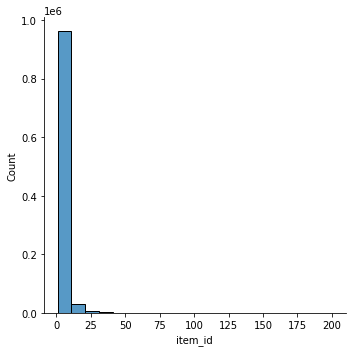

In [25]:
df_clicks_by_session = clicks.groupby(["session_id"])
df_clicks_sessionCount = df_clicks_by_session["item_id"].count()
sns.displot(df_clicks_sessionCount, kde=False, bins=20)

In [19]:
# # Sampling
# item_encoder = LabelEncoder()
# clicks['item_id'] = item_encoder.fit_transform(clicks.item_id)
# sampled_session_id = np.random.choice(clicks.session_id.unique(), 1000000, replace=False)
# clicks = clicks.loc[clicks.session_id.isin(sampled_session_id)]
# clicks['label'] = clicks.session_id.isin(buys.session_id)

In [27]:
%%writefile data.py

# -*- coding: utf-8 -*-
"""
create on 18 Sep, 2019

@author: wangshuo

Reference: https://github.com/lijingsdu/sessionRec_NARM/blob/master/data_process.py
"""

import pickle
import torch
from torch.utils.data import Dataset
import numpy as np


def load_data(root, valid_portion=0.1, maxlen=19, sort_by_len=False):
    '''Loads the dataset

    :type path: String
    :param path: The path to the dataset (here RSC2015)
    :type n_items: int
    :param n_items: The number of items.
    :type valid_portion: float
    :param valid_portion: The proportion of the full train set used for
        the validation set.
    :type maxlen: None or positive int
    :param maxlen: the max sequence length we use in the train/valid set.
    :type sort_by_len: bool
    :name sort_by_len: Sort by the sequence lenght for the train,
        valid and test set. This allow faster execution as it cause
        less padding per minibatch. Another mechanism must be used to
        shuffle the train set at each epoch.

    '''

    # Load the dataset
    path_train_data = root + 'train.txt'
    path_test_data = root + 'test.txt'
    with open(path_train_data, 'rb') as f1:
        train_set = pickle.load(f1)

    with open(path_test_data, 'rb') as f2:
        test_set = pickle.load(f2)

    if maxlen:
        new_train_set_x = []
        new_train_set_y = []
        for x, y in zip(train_set[0], train_set[1]):
            if len(x) < maxlen:
                new_train_set_x.append(x)
                new_train_set_y.append(y)
            else:
                new_train_set_x.append(x[:maxlen])
                new_train_set_y.append(y)
        train_set = (new_train_set_x, new_train_set_y)
        del new_train_set_x, new_train_set_y

        new_test_set_x = []
        new_test_set_y = []
        for xx, yy in zip(test_set[0], test_set[1]):
            if len(xx) < maxlen:
                new_test_set_x.append(xx)
                new_test_set_y.append(yy)
            else:
                new_test_set_x.append(xx[:maxlen])
                new_test_set_y.append(yy)
        test_set = (new_test_set_x, new_test_set_y)
        del new_test_set_x, new_test_set_y

    # split training set into validation set
    train_set_x, train_set_y = train_set
    n_samples = len(train_set_x)
    sidx = np.arange(n_samples, dtype='int32')
    np.random.shuffle(sidx)
    n_train = int(np.round(n_samples * (1. - valid_portion)))
    valid_set_x = [train_set_x[s] for s in sidx[n_train:]]
    valid_set_y = [train_set_y[s] for s in sidx[n_train:]]
    train_set_x = [train_set_x[s] for s in sidx[:n_train]]
    train_set_y = [train_set_y[s] for s in sidx[:n_train]]

    (test_set_x, test_set_y) = test_set

    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))

    if sort_by_len:
        sorted_index = len_argsort(test_set_x)
        test_set_x = [test_set_x[i] for i in sorted_index]
        test_set_y = [test_set_y[i] for i in sorted_index]

        sorted_index = len_argsort(valid_set_x)
        valid_set_x = [valid_set_x[i] for i in sorted_index]
        valid_set_y = [valid_set_y[i] for i in sorted_index]

    train = (train_set_x, train_set_y)
    valid = (valid_set_x, valid_set_y)
    test = (test_set_x, test_set_y)

    return train, valid, test


class RecSysDataset(Dataset):
    """define the pytorch Dataset class for yoochoose and diginetica datasets.
    """
    def __init__(self, data):
        self.data = data
        print('-'*50)
        print('Dataset info:')
        print('Number of sessions: {}'.format(len(data[0])))
        print('-'*50)
        
    def __getitem__(self, index):
        session_items = self.data[0][index]
        target_item = self.data[1][index]
        return session_items, target_item

    def __len__(self):
        return len(self.data[0])

Writing data.py
